<a href="https://colab.research.google.com/github/Nicordaro/Project_MLDL/blob/master/Project_MLDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Politecnico di Torino**

**01TXFSM - Machine learning and Deep learning**

**Incremental Learning in Image Classification**

**Cordaro Nicolò - s272145**

**Di Nepi Marco - s277959**

**Falletta Alberto - s277971**


In [0]:
# !pip3 install 'torch==1.4.0'
# !pip3 install 'torchvision==0.5.0'
# !pip3 install 'Pillow-SIMD'
# !pip3 install 'tqdm'

**Imports**

In [0]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn


import torchvision
from torchvision import transforms
from torchvision.models import resnet18
from torchvision.models import resnet34
from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt
from google.colab import drive

**Arguments**

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

# Init at 10 because first train is on 10 classes
NUM_CLASSES = 10

# Used for the pseudorandom shuffle of the split
SEED = 42

BATCH_SIZE = 128     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 2               # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 70      # Total number of training epochs (iterations over dataset)
MILESTONES = [48, 62]  # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.2          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 50

**Pre-processing**

In [0]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))  # https://gist.github.com/weiaicunzai/e623931921efefd4c331622c344d8151
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))                                 
])

**Prepare Dataset**

CIFAR100 has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another.

Each of the downloaded files is a Python "pickled" object produced with cPickle.

In [5]:
# Clone github repository with data
# if os.path.isdir('./Project_MLDL'):
!rm -rf Project_MLDL
if not os.path.isdir('./CIFAR100_tError'):
  !git clone https://github.com/Nicordaro/Project_MLDL


Cloning into 'Project_MLDL'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 113 (delta 50), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (113/113), 198.85 KiB | 1.01 MiB/s, done.
Resolving deltas: 100% (50/50), done.


In [0]:
from Project_MLDL.CIFAR100_tError import CIFAR100_tError
import numpy as np
import random

DATA_DIR = './CIFAR100'

lbls = [i for i in range(0,100)]  #Array of classes integer-encoded (?)
random.seed(SEED)
random.shuffle(lbls)

def make_data_labels(lbls):       #After shuffle, take first 10 classes, and remove the first 10 from the list passed as argument
  new_labels=[]
  for el in lbls[:10]:
    new_labels.append(el)
  lbls = lbls[10:]

  return lbls, new_labels

**Network Definition**

In [0]:
net = resnet34(pretrained=False)

**Train & Test**

In [8]:
import numpy as np
BATCH_TO_TEST = 10
accuracies = []

# Define test dataset outside in order to increment it, instead of initializing it every cycle iteration
test_dataset = CIFAR100_tError(DATA_DIR, train=False, transform=eval_transform, download=True)
for i in range(0,BATCH_TO_TEST): #one iteration for 10 classes
  print(f'Starting training with batch {i+1}')
  lbls, new_labels = make_data_labels(lbls)
  
  # Define Train dataset
  train_dataset = CIFAR100_tError(DATA_DIR, train=True, transform=train_transform, download=True)       
  
  # Increment dataset with new labels mapped with list comprehension
  train_dataset.increment(new_labels,[j for j in range(0+i*10,10+i*10)])
  test_dataset.increment(new_labels,[j for j in range(0+i*10,10+i*10)])

  # Change number of neurons in last fully connected layer
  net.fc = nn.Linear(512, NUM_CLASSES*(i+1))

  # Define dataloader
  train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
  test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

  #prepare training
  # Loss function
  criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

  # Parameters to optimize:
  parameters_to_optimize = net.parameters()

  # Optimizer
  optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
  # Scheduler
  scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=MILESTONES, gamma=GAMMA, last_epoch=-1)

  # training 
  # By default, everything is loaded to cpu
  net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

  cudnn.benchmark # Calling this optimizes runtime

  current_step = 0

  # Start iterating over the epochs
  for epoch in range(NUM_EPOCHS):
    # if epoch==5:
    #   for g in optimizer.param_groups:
    #     g['lr'] = g['lr']/5
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))
    
    # Iterate over the dataset
    for images, labels in train_dataloader:
      # Bring data over the device of choice
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      net.train() # Sets module in training mode

      # PyTorch, by default, accumulates gradients after each backward pass
      # We need to manually set the gradients to zero before starting a new iteration
      optimizer.zero_grad() # Zero-ing the gradients

      # Forward pass to the network
      outputs = net(images)

      # Compute loss based on output and ground truth
      loss = criterion(outputs, labels)
      
      if current_step % LOG_FREQUENCY == 0:
        print('Step {}, Loss {}'.format(current_step, loss.item()))

      # Compute gradients for each layer and update weights
      loss.backward()  # backward pass: computes gradients
      optimizer.step() # update weights based on accumulated gradients

      current_step += 1

    # Step the scheduler
    scheduler.step()

  #test phase
  net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  net.train(False) # Set Network to evaluation mode

  running_corrects = 0
  for images, labels in tqdm(test_dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass
    outputs = net(images)

    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    #Debugging purpose, print labels of predictions
    ##print(preds)

    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

  # Calculate Accuracy
  accuracy = running_corrects / float(len(test_dataset))

  #Store accuracies for plotting purposes
  accuracies.append(accuracy)

  print('Test Accuracy: {}'.format(accuracy))

Extracting ./CIFAR100/cifar-100-python.tar.gz to ./CIFAR100
Starting training with batch 1
Files already downloaded and verified
Starting epoch 1/70, LR = [2]
Step 0, Loss 2.599404811859131
Starting epoch 2/70, LR = [2]
Step 50, Loss 2.3513941764831543
Starting epoch 3/70, LR = [2]
Step 100, Loss 2.325427532196045
Starting epoch 4/70, LR = [2]
Step 150, Loss 2.2784812450408936
Starting epoch 5/70, LR = [2]
Starting epoch 6/70, LR = [2]
Step 200, Loss 2.269152879714966
Starting epoch 7/70, LR = [2]
Step 250, Loss 2.3110673427581787
Starting epoch 8/70, LR = [2]
Step 300, Loss 2.3017289638519287
Starting epoch 9/70, LR = [2]
Step 350, Loss 2.362398147583008
Starting epoch 10/70, LR = [2]
Starting epoch 11/70, LR = [2]
Step 400, Loss 2.287203550338745
Starting epoch 12/70, LR = [2]
Step 450, Loss 2.289388418197632
Starting epoch 13/70, LR = [2]
Step 500, Loss 2.232065439224243
Starting epoch 14/70, LR = [2]
Starting epoch 15/70, LR = [2]
Step 550, Loss 2.265521287918091
Starting epoch 16/

100%|██████████| 8/8 [00:04<00:00,  1.99it/s]


Test Accuracy: 0.655
Starting training with batch 2
Files already downloaded and verified
Starting epoch 1/70, LR = [2]
Step 0, Loss 2.9818334579467773
Starting epoch 2/70, LR = [2]
Step 50, Loss 1.4810218811035156
Starting epoch 3/70, LR = [2]
Step 100, Loss 1.3561558723449707
Starting epoch 4/70, LR = [2]
Step 150, Loss 1.0600697994232178
Starting epoch 5/70, LR = [2]
Starting epoch 6/70, LR = [2]
Step 200, Loss 0.7479666471481323
Starting epoch 7/70, LR = [2]
Step 250, Loss 0.5653940439224243
Starting epoch 8/70, LR = [2]
Step 300, Loss 0.7145154476165771
Starting epoch 9/70, LR = [2]
Step 350, Loss 0.8447251915931702
Starting epoch 10/70, LR = [2]
Starting epoch 11/70, LR = [2]
Step 400, Loss 0.5509843230247498
Starting epoch 12/70, LR = [2]
Step 450, Loss 0.47824323177337646
Starting epoch 13/70, LR = [2]
Step 500, Loss 0.5084443092346191
Starting epoch 14/70, LR = [2]
Starting epoch 15/70, LR = [2]
Step 550, Loss 0.4519962966442108
Starting epoch 16/70, LR = [2]
Step 600, Loss 0.

100%|██████████| 16/16 [00:07<00:00,  2.20it/s]


Test Accuracy: 0.358
Starting training with batch 3
Files already downloaded and verified
Starting epoch 1/70, LR = [2]
Step 0, Loss 3.4039359092712402
Starting epoch 2/70, LR = [2]
Step 50, Loss 0.921224057674408
Starting epoch 3/70, LR = [2]
Step 100, Loss 0.644908607006073
Starting epoch 4/70, LR = [2]
Step 150, Loss 0.6853855848312378
Starting epoch 5/70, LR = [2]
Starting epoch 6/70, LR = [2]
Step 200, Loss 0.4130040407180786
Starting epoch 7/70, LR = [2]
Step 250, Loss 0.3102909326553345
Starting epoch 8/70, LR = [2]
Step 300, Loss 0.44516581296920776
Starting epoch 9/70, LR = [2]
Step 350, Loss 0.3713524341583252
Starting epoch 10/70, LR = [2]
Starting epoch 11/70, LR = [2]
Step 400, Loss 0.14933505654335022
Starting epoch 12/70, LR = [2]
Step 450, Loss 0.2480635643005371
Starting epoch 13/70, LR = [2]
Step 500, Loss 0.1367146074771881
Starting epoch 14/70, LR = [2]
Starting epoch 15/70, LR = [2]
Step 550, Loss 0.12612196803092957
Starting epoch 16/70, LR = [2]
Step 600, Loss 0.

100%|██████████| 24/24 [00:10<00:00,  2.21it/s]


Test Accuracy: 0.259
Starting training with batch 4
Files already downloaded and verified
Starting epoch 1/70, LR = [2]
Step 0, Loss 3.6945881843566895
Starting epoch 2/70, LR = [2]
Step 50, Loss 0.8986314535140991
Starting epoch 3/70, LR = [2]
Step 100, Loss 0.7700833082199097
Starting epoch 4/70, LR = [2]
Step 150, Loss 0.6970995664596558
Starting epoch 5/70, LR = [2]
Starting epoch 6/70, LR = [2]
Step 200, Loss 0.35926252603530884
Starting epoch 7/70, LR = [2]
Step 250, Loss 0.2482171356678009
Starting epoch 8/70, LR = [2]
Step 300, Loss 0.36471861600875854
Starting epoch 9/70, LR = [2]
Step 350, Loss 0.17567673325538635
Starting epoch 10/70, LR = [2]
Starting epoch 11/70, LR = [2]
Step 400, Loss 0.2947806715965271
Starting epoch 12/70, LR = [2]
Step 450, Loss 0.24779972434043884
Starting epoch 13/70, LR = [2]
Step 500, Loss 0.5235915184020996
Starting epoch 14/70, LR = [2]
Starting epoch 15/70, LR = [2]
Step 550, Loss 0.19853475689888
Starting epoch 16/70, LR = [2]
Step 600, Loss 0

100%|██████████| 32/32 [00:13<00:00,  2.37it/s]


Test Accuracy: 0.172
Starting training with batch 5
Files already downloaded and verified
Starting epoch 1/70, LR = [2]
Step 0, Loss 3.92444109916687
Starting epoch 2/70, LR = [2]
Step 50, Loss 0.9572309255599976
Starting epoch 3/70, LR = [2]
Step 100, Loss 0.5366849899291992
Starting epoch 4/70, LR = [2]
Step 150, Loss 0.6000600457191467
Starting epoch 5/70, LR = [2]
Starting epoch 6/70, LR = [2]
Step 200, Loss 0.2612517774105072
Starting epoch 7/70, LR = [2]
Step 250, Loss 0.3818824291229248
Starting epoch 8/70, LR = [2]
Step 300, Loss 0.3079017102718353
Starting epoch 9/70, LR = [2]
Step 350, Loss 0.3020949065685272
Starting epoch 10/70, LR = [2]
Starting epoch 11/70, LR = [2]
Step 400, Loss 0.3375851511955261
Starting epoch 12/70, LR = [2]
Step 450, Loss 0.06319212168455124
Starting epoch 13/70, LR = [2]
Step 500, Loss 0.4094850420951843
Starting epoch 14/70, LR = [2]
Starting epoch 15/70, LR = [2]
Step 550, Loss 0.26683780550956726
Starting epoch 16/70, LR = [2]
Step 600, Loss 0.2

100%|██████████| 40/40 [00:17<00:00,  2.28it/s]


Test Accuracy: 0.1596
Starting training with batch 6
Files already downloaded and verified
Starting epoch 1/70, LR = [2]
Step 0, Loss 4.105536937713623
Starting epoch 2/70, LR = [2]
Step 50, Loss 0.8795164823532104
Starting epoch 3/70, LR = [2]
Step 100, Loss 0.6897817254066467
Starting epoch 4/70, LR = [2]
Step 150, Loss 0.45181092619895935
Starting epoch 5/70, LR = [2]
Starting epoch 6/70, LR = [2]
Step 200, Loss 0.30491772294044495
Starting epoch 7/70, LR = [2]
Step 250, Loss 0.2239166796207428
Starting epoch 8/70, LR = [2]
Step 300, Loss 0.2638661861419678
Starting epoch 9/70, LR = [2]
Step 350, Loss 0.3417397141456604
Starting epoch 10/70, LR = [2]
Starting epoch 11/70, LR = [2]
Step 400, Loss 0.10941185057163239
Starting epoch 12/70, LR = [2]
Step 450, Loss 0.2920811176300049
Starting epoch 13/70, LR = [2]
Step 500, Loss 0.15879501402378082
Starting epoch 14/70, LR = [2]
Starting epoch 15/70, LR = [2]
Step 550, Loss 0.19841426610946655
Starting epoch 16/70, LR = [2]
Step 600, Los

100%|██████████| 47/47 [00:19<00:00,  2.41it/s]


Test Accuracy: 0.125
Starting training with batch 7
Files already downloaded and verified
Starting epoch 1/70, LR = [2]
Step 0, Loss 4.256866931915283
Starting epoch 2/70, LR = [2]
Step 50, Loss 0.7277020215988159
Starting epoch 3/70, LR = [2]
Step 100, Loss 0.7889624834060669
Starting epoch 4/70, LR = [2]
Step 150, Loss 0.4668240249156952
Starting epoch 5/70, LR = [2]
Starting epoch 6/70, LR = [2]
Step 200, Loss 0.1768980324268341
Starting epoch 7/70, LR = [2]
Step 250, Loss 0.3814014196395874
Starting epoch 8/70, LR = [2]
Step 300, Loss 0.17102579772472382
Starting epoch 9/70, LR = [2]
Step 350, Loss 0.220466747879982
Starting epoch 10/70, LR = [2]
Starting epoch 11/70, LR = [2]
Step 400, Loss 0.12889552116394043
Starting epoch 12/70, LR = [2]
Step 450, Loss 0.23855236172676086
Starting epoch 13/70, LR = [2]
Step 500, Loss 0.24361436069011688
Starting epoch 14/70, LR = [2]
Starting epoch 15/70, LR = [2]
Step 550, Loss 0.11367493867874146
Starting epoch 16/70, LR = [2]
Step 600, Loss 

100%|██████████| 55/55 [00:24<00:00,  2.20it/s]


Test Accuracy: 0.11057142857142857
Starting training with batch 8
Files already downloaded and verified
Starting epoch 1/70, LR = [2]
Step 0, Loss 4.366513729095459
Starting epoch 2/70, LR = [2]
Step 50, Loss 0.755964994430542
Starting epoch 3/70, LR = [2]
Step 100, Loss 0.6557167768478394
Starting epoch 4/70, LR = [2]
Step 150, Loss 1.0425575971603394
Starting epoch 5/70, LR = [2]
Starting epoch 6/70, LR = [2]
Step 200, Loss 0.3445008397102356
Starting epoch 7/70, LR = [2]
Step 250, Loss 0.2443159818649292
Starting epoch 8/70, LR = [2]
Step 300, Loss 0.16117584705352783
Starting epoch 9/70, LR = [2]
Step 350, Loss 0.27895379066467285
Starting epoch 10/70, LR = [2]
Starting epoch 11/70, LR = [2]
Step 400, Loss 0.4115810990333557
Starting epoch 12/70, LR = [2]
Step 450, Loss 0.27117010951042175
Starting epoch 13/70, LR = [2]
Step 500, Loss 0.280640572309494
Starting epoch 14/70, LR = [2]
Starting epoch 15/70, LR = [2]
Step 550, Loss 0.09723512828350067
Starting epoch 16/70, LR = [2]
Ste

100%|██████████| 63/63 [00:26<00:00,  2.41it/s]


Test Accuracy: 0.09725
Starting training with batch 9
Files already downloaded and verified
Starting epoch 1/70, LR = [2]
Step 0, Loss 4.507180213928223
Starting epoch 2/70, LR = [2]
Step 50, Loss 0.885940432548523
Starting epoch 3/70, LR = [2]
Step 100, Loss 0.9159364104270935
Starting epoch 4/70, LR = [2]
Step 150, Loss 0.722427248954773
Starting epoch 5/70, LR = [2]
Starting epoch 6/70, LR = [2]
Step 200, Loss 0.48447054624557495
Starting epoch 7/70, LR = [2]
Step 250, Loss 0.3572623133659363
Starting epoch 8/70, LR = [2]
Step 300, Loss 0.2777395248413086
Starting epoch 9/70, LR = [2]
Step 350, Loss 0.3263169825077057
Starting epoch 10/70, LR = [2]
Starting epoch 11/70, LR = [2]
Step 400, Loss 0.2238287329673767
Starting epoch 12/70, LR = [2]
Step 450, Loss 0.15063993632793427
Starting epoch 13/70, LR = [2]
Step 500, Loss 0.3083972930908203
Starting epoch 14/70, LR = [2]
Starting epoch 15/70, LR = [2]
Step 550, Loss 0.2063387632369995
Starting epoch 16/70, LR = [2]
Step 600, Loss 0.

100%|██████████| 71/71 [00:34<00:00,  2.06it/s]


Test Accuracy: 0.08044444444444444
Starting training with batch 10
Files already downloaded and verified
Starting epoch 1/70, LR = [2]
Step 0, Loss 4.582775592803955
Starting epoch 2/70, LR = [2]
Step 50, Loss 0.6804217100143433
Starting epoch 3/70, LR = [2]
Step 100, Loss 0.4433596730232239
Starting epoch 4/70, LR = [2]
Step 150, Loss 0.6029201745986938
Starting epoch 5/70, LR = [2]
Starting epoch 6/70, LR = [2]
Step 200, Loss 0.337808221578598
Starting epoch 7/70, LR = [2]
Step 250, Loss 0.2989194393157959
Starting epoch 8/70, LR = [2]
Step 300, Loss 0.25154778361320496
Starting epoch 9/70, LR = [2]
Step 350, Loss 0.3910529613494873
Starting epoch 10/70, LR = [2]
Starting epoch 11/70, LR = [2]
Step 400, Loss 0.3461727499961853
Starting epoch 12/70, LR = [2]
Step 450, Loss 0.06241236627101898
Starting epoch 13/70, LR = [2]
Step 500, Loss 0.09909180551767349
Starting epoch 14/70, LR = [2]
Starting epoch 15/70, LR = [2]
Step 550, Loss 0.07447581738233566
Starting epoch 16/70, LR = [2]
S

100%|██████████| 79/79 [00:32<00:00,  2.43it/s]

Test Accuracy: 0.0749


In [12]:
print(accuracies)
# accuracies = [0.655, 0.358, 0.259, 0.172, 0.1596, 0.125, 0.11057142857142857, 0.09725, 0.08044444444444444, 0.0749]

[0.655, 0.358, 0.259, 0.172, 0.1596, 0.125, 0.11057142857142857, 0.09725, 0.08044444444444444, 0.0749]


**Define plot function**

In [0]:
def accuracy_plot(accuracies):
  from scipy import interpolate

  tck,u     = interpolate.splprep( [[i*10 for i in range(1,len(accuracies)+1)],accuracies] ,s = 0 )
  xnew,ynew = interpolate.splev( np.linspace( 0, 1, 100 ), tck,der = 0)

  fig, ax = plt.subplots(figsize=(15,14), facecolor='white')

  plt.rc('font', size=20)
  plt.plot( [i*10 for i in range(1,len(accuracies)+1)],accuracies,'.' , xnew ,ynew, label = "accuracy", c='orange' )
  ax.set_ylabel("Accuracy")
  ax.set_xlabel("Classes")
  ax.minorticks_on()
  plt.title("Accuracies obtained with finetuning of a ResNet network")
  # # Customize the major grid
  # ax.grid(which='major', linestyle='-', linewidth='0.5', color='red')
  # # Customize the minor grid
  # ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
  plt.yticks(np.arange(0, 1.1, .1))
  plt.xticks(np.arange(0, 110, 10))
  plt.grid(axis='y',which='major', linestyle='-', linewidth='0.5', color='black') 
  plt.grid(axis='y',which='minor', linestyle=':', linewidth='0.5', color='grey')
  for in_i, in_j in zip([i*10 for i in range(1,len(accuracies)+1)], accuracies):  # Plot also the value of the point close to it
          ax.annotate(str(round(in_j, 3)), xy=(in_i, in_j))

  plt.savefig('test.png', format='png', dpi=300)
  plt.show()

**Plot accuracies**

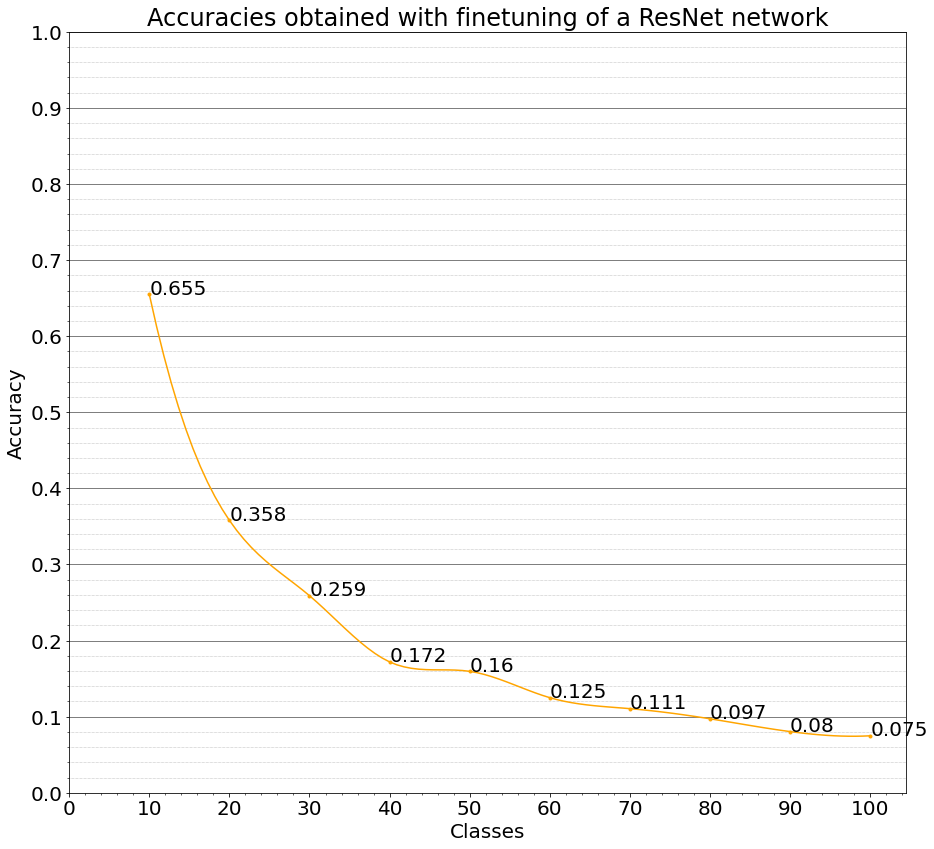

In [42]:
accuracy_plot(accuracies)